In [6]:
### Identify the point mutations and write them into a separate file
from liftover import get_lifter
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname='/nfs/users/nfs_e/er10/fonts/arial.ttf',
    name='my_arial')
fm.fontManager.ttflist.insert(0, fe) # or append is fine
mpl.rcParams['font.family'] = fe.name # = 'your custom ttf font name'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['text.color'] = 'k'
mpl.rcParams['axes.labelcolor'] = 'k'
mpl.rcParams['xtick.color'] = 'k'
mpl.rcParams['ytick.color'] = 'k'
import matplotlib.patches as mpatches

%matplotlib inline

In [2]:
data_root='/nfs/users/nfs_e/er10/SGE/DDX3X_paper/Revised/'
out_files='/nfs/users/nfs_e/er10/SGE/DDX3X_paper/Figure_plots/'

In [7]:
SGE_info={}
with open(data_root+'Table_S9_SGE_data_for_all_variants_tested_with_annotation2.txt', 'r')as f:
    header=f.readline().strip().split('\t')
    pos_col=header.index('VCF_position')
    ref_col=header.index('VCF_Ref')
    alt_col=header.index('VCF_Alt')
    time_cluster_col=header.index('SGE_functional_classification')
    VEP_col=header.index('Primary_consequence')
    lines=f.readlines()
    for line in lines:
        fields=line.strip().split('\t')
        pos=fields[pos_col].strip()
        ref=fields[ref_col].strip('""')
        alt=fields[alt_col].strip('""')
        cluster = fields[time_cluster_col].strip()
        VEP=fields[VEP_col].strip()
        SGE_info[(int(pos), ref, alt)] = (cluster, VEP)

In [8]:
'''missense variants: These are the summed probabilities of each SGE functional class of variants arising by chance (ie mutational rates)'''

DDX3X_missense_mutational_probabilities=[]
miss_FD_prob=[]
miss_SD_prob=[]
miss_U_prob=[]
miss_E_prob=[]
found=[]
with open(data_root+'Supp_Table7_DDX3X_all_snvs_mutation_probs.txt', 'r') as f:
    header=f.readline().strip().split('\t')
    #print(header)
    pos_col=header.index('DNA_pos')
    ref_col=header.index('ref_base')
    alt_col=header.index('alt_base')
    prob_col=header.index('probability')
    lines=f.readlines()
    for line in lines:
        fields=line.strip().split('\t')
        pos=fields[pos_col].strip()
        ref=fields[ref_col].strip('""')
        alt=fields[alt_col].strip('""')
        prob=float(fields[prob_col].strip('""'))
        try:
            cluster, lookup_cons=SGE_info[(int(pos), ref, alt)]
            if 'missense' in lookup_cons:
                DDX3X_missense_mutational_probabilities.append(prob)
                if cluster == 'fast depleting':
                    miss_FD_prob.append(prob)
                elif cluster == 'slow depleting':
                    miss_SD_prob.append(prob)
                elif cluster == 'enriched':
                    miss_E_prob.append(prob)
                elif cluster == 'unchanged':
                    miss_U_prob.append(prob)
                else:
                    print('unhandled cluster', cluster)
        except KeyError:
            pass
sum_DDX3X_missense_probs=np.sum(DDX3X_missense_mutational_probabilities)            
miss_chance_FD=np.sum(miss_FD_prob)/sum_DDX3X_missense_probs
miss_chance_SD=np.sum(miss_SD_prob)/sum_DDX3X_missense_probs
miss_chance_E=np.sum(miss_E_prob)/sum_DDX3X_missense_probs
miss_chance_U=np.sum(miss_U_prob)/sum_DDX3X_missense_probs

In [9]:
hg19_min=41193480
hg19_max=41206987

#hg38 coordinates
DDX3X_start=41333284
DDX3X_end=41351668
#sequence includes 5'UTRs and introns, i.e. is gDNA sequence of the above coordinates.
DDX3X_seq='CCGCTGCCTAGGCAACCGCGCAGGAAGGTGTCCGGCCACCTGCGCGCGCCGCCGGCTCCCCTCCATTTCCCCCCGACTCCCGCCCCGGTCACCATCCTACCCTCCTCCCTCCTCCTTTCCCCTTACTCCGCTCCCCTCTTTTCCCTCCCTCTCCTCCCCTTCCCTCTGTTCTCTCCTCCTCTTCCCCTCCCCTCCCCCGTCCGGAGCACTCTATATTCAAGCCACCGTTTCCTGCTTCACAAAATGGCCACCGCACGCGACACCTACGGTCACGTGGCCTGCCGCCCTCTCAGTTTCGGGAATCTGCCTAGCTCCCACTAAGGGGAGGCTACCCGCGGAAGAGCGAGGGCAGATTAGACCGGAGAAATCCCACCACATCTCCAAGCCCGGGAACTGAGAGAGGAAGAAGAGTGAAGGCCAGTGTTAGGAAAAAAAAAACAAAAACAAAAAAAACGAAAAACGAAAGCTGAGTGCATAGAGTTGGAAAGGGGAGCGAATGCGTAAGGTTGGAAAGGGGGGCGAAGAGGCCTAGGTTAACATTTTCAGGCGTCTTAGCCGGTGGAAAGCGGGAGACGCAAGTTCTCGCGAGATCTCGAGAACTCCGAGGCTGAGACTAGGGTTTTAGCGGAGAGCACGGGAAGTGTAGCTCGAGAGAACTGGGACAGCATTTCGCACCCTAAGCTCCAAGGCAGGACTGCTAGGGGCGACAGGACTAAGTAGGAAATCCCTTGAGCTTAGACCTGAGGGAGCGCGCAGTAGCCGGGCAGAAGTCGCCGCGACAGGGAATTGCGGTGTGAGAGGGAGGGCACACGTTGTACGTGCTGACGTAGCCGGCTTTCCAGCGGGTATATTAGATCCGTGGCCGCGCGGTGCGCTCCAGAGCCGCAGTTCTCCCGTGAGAGGGCCTTCGCGGTGGAACAAACACTCGCTTAGCAGCGGAAGACTCCGAGTTCTCGGTACTCTTCAGGGATGAGTCATGTGGCAGTGGAAAATGCGCTCGGGCTGGACCAGCAGGTGAGCCGCAAGAACCCCACCGGGCTGGCTGCTGCGTGAATTCCTCCCCTGACCTAACCTGGCTAATGGCGCAGCGCTAACCGGCACCCTTACTTTTCATTTTCTGGGTGCCCCGGGCTGGCGGGTGTGAGTGCCCCGGGGCTATAGAGGGATAGGAATGTTGGTTGGGGCTGTCGCCCGGGCCCGGTCTCGGCCCGCTGTATTGTCCCCGGGACGAGCACAATGGCGGCTTTTGTGTGTGCGTGCGCAGGCGGGCGGAGGGGGAGGAAGTGCGCGCGCTCTCGCGGGGACGCGCATGCGCGAATCCCGACTGATTAGTGACCTGGGGGGGTTTGCGGGAGTGCGCAGCGCGGCGGGACGCGACTGGAGGCCCTTTTGGCTTGGAGGGCTTCGGCCTTCACGGCTGGCGCAGCCTGGATTCCCGTCCGGAGGACCTGGCGGCACCCGGTGTTTGCGTGCCTGCGAGCAAGGGGTAGAACGCGGCCCAGGAATGTGGGAGGGGGCGGCCTTCGCTCGGGGTAATGGCGGCGGCCTCTTTTGTGTGGTGCTGGGCGGCGCTGTGGCTCACCTCCGGGAGACGGCGGGTCTCGGGCGGGCGAAGGCCTGGAAAGGAGGATGGAATGGGTTTCTTGTTTTTTCCCGGGTTCCTTCCGCTGGCTTTTTCGCTTCAGCCCAGGTTCCGCAGGGTCCGGGGGCCCTGCGCCGCAGCCGGGGAGGCTGCGTTTCCGGAGTGGAAAGTTTTGTGACGCAGAAGATTGGGGAGGAGTGGGGGAGGGGTGGGGGCGGGGAGGGGAGGCAGGAATTGGCCGCTGCGCGCTGGGCCCTGGAGATAGAGGTTGGACGTGGCGGGGAGGTTAGGGAGCCAGCGAGGCCCTTTCTCCTCCTTGCTTGCCCCAGATTGTCCCTGTGTGGTATGTTAGCCGGGAGTCCCGCGTTGTTTTTCTGGGGTGGAGGGGTCATCGCGGGTTGTGGTAGTGTCTTCGTGTTAGTGACTGTGATCCAGGAATCCGCCATTGGAAAAACACCCGGCTTAGGGGGGAAGTAAACAGTTTTGTTGTTGACTTGTTGCTATCTGTGGAGTAGAATCTTGCAATGGGTCCCAGGCCCCCGGGTTTTTTCTCTTAGCCAGAATCCCCTCTTCTAAGGGTTTAGGGGCAGAGGAGAGAAAGATGTGTGATTTGAGAGGAGAAGGTTATGGACTTTGGTGGCAGGAAGTCTGCATCCCACCGCAACAGTGGCACCAGGCTTCAGATAAGCTCTTGTGTGGGTTATGCGGAGCTTTTAAATAAACTACTGTCTACTGTGATTAGGGGAGCGTTGATTTCACAAACTCCGGAATAATCCTGAGACGAAGTTTAGTGGCACAAATTAATTGAATACATAGTTTAATGTAGTCATATGTAATATTTTTTAGGAATTGATCTGTTCCTTTGGAAGCATTTTCTACCCGTTAATGAACCAATTATATTAAATCCTCTAATTGCTGACACATGTTGAATTGAACAGACACTTTAACAACCTACCAGCAGCACAGAGTATTCCCAGTTTTACCATTTTCCATTTAGCTATAGTGTCCTTTTAAGGATTCTAGGCAACAGTGAACCTTATTTAAAAAGCAAAATTGTGCTATAACAAGTGCAAAAGGAAAGTTTGTGTTCCTACCGTGCTTTAAAGTATTGATGGTAGCAAGAGAAAGCGCAGTGGTGTTTTTGCTCATAGAAATTCTGGAAATTAGGTGCCTGAAGTCTTACACTCATTTTTTAAAAGTATAGCATCTGCTTCCAGTTTTCAGTGACTCCATTGATGATGCATGCGGTTTGGCCGTATCATACTGAGCTTTAAACACAAGATTTATAAACATGGTATGTAGTGCATCTTTTGCAAACAGGTTGGCAGCGGTACTGTGTGACTTGGTCTTTTGTGGCTTTTTTGAGAAAAATGAAACACTTTGCATGTATAGTTTTTTCTCCCAACTACTTGTGAGTAGTTCCTGGTTATAAAACGTTATGAAGGTAGCACATAACCCTTTTCTAGAATGAAGAGGCTTTTGAGCTACCAGTGTAAGGGGATAGGTAGAAATAGAGATGAAAGGCACTAAGATGTCCTACTCTTTAAGAGCATTGAACGCCAGTTGTGCCATTTATTCAAAGTCATCTTTGAACTTATGTTAAAATGGGGTAAAAACAGGTAACTACTTCAGGCCGGGCTCATGCTTGTAATCCCAGTGCTTTGGGAGGCCAAGGCAGGTGGTTCACCTGACCTGAGGTCAGGAGACCAGCCTGGGCAACATGGCGAAACCCCATCTCTACTAAAAGTACAAAAAGTAGCCTAGCGTGGTGGCGCACCCCTGTAATCCCAGCTACTCGGGGAGGTGGAGGTTGCAGTGAGCCGAGATCACATGACTGAATTCCAGCCTGGATGACAGAGGGAGACTCTGTCTCAAAAAAAATAAAAATAAAAACAAACGAAACAGTCAAACTACTTAAGAGTTGTGCTTAACATAGTGTTCTGTAAGTGGTAGGTATATTGCTATTTTTTTGTTGTTCTTAAGAGTACTACCCGACTAAAAATACTTGGGCAATATTTAGGGATGAAGTATCTAACTAAAAGAACGGCCACTTCGAAATTTGTCCTGACATTTTTCAGGTGTGCATTTTAGGTTTAAAATATCAAGTATTACGGAAAGTTGGCATTGGAAACTTTCATAACCGGCACTAAAACGAATCCTTTATCTATTTGACATTGAGGAATAATTTTGAGATTCAGTGTAAGCTTTAGTTTGGTGATTAGGGAGCCTGTGCTATGGAACATGTTAGTGAAAATTTATTTTGAATGCATGAATTAAATTTGGACAGTTTCTACTGAACAGCACAAGCATCTTGGTGTGCCGCCTTCTGTAGTATATACAATAGTAATATTGCATTTGCTTAGAGCATTGCAGACTTGAAAACATTCTTAGTCACATTCTCATTAAGGGTTGGTATTAGCCCTGTGAGGTGGACTGGGCAACTACTTGAATGCAGTACTAGCAAATGCTAGAGGGCAGGACTAGTTTTCTCTTAATGTAGTATTTGAGCACATGGGGTGCTAACCATCTCACTCTCTTCTAGTTTGCTGGCCTAGACCTGAACTCTTCAGATAATCAGAGTGGAGGAAGTACAGCCAGCAGTAAGTACAACATCTTGTGGGTTTATTGAATATTAGAGCTTAACATCTTAAGATTTCATTGGGCTTATGTAAAATTTAAGAAATTTGCCTTTCAATTTTTTACTGCTTAAAGAATTATGTAGTCTTTGTGTTATAGAATTATGTAGTACTTAGTGATCAATCTAAAGCATCGTTGCCTTTTTTTTTTTTTTTTGGTTGAGATGGAGCTTTGCTCTTGTTGCCCAGGTTGGAGTGCAATGGTGTGATCTCGGCTCACCGCAGTCTCTGCCTCCGGGTTCAAGCGATTCTCCTGCCTCAGCCTCCCGAATAGCTGTGCCTTTCTGATAATAAAACATCAATGACTAGCTGGCTCTCTTGAGTAAAAGCAGCTAATCATTGGAAAGAACCTTATTATATCAAATTATCTCTAGAAGAGTTTTTGTCCATTATAAATCCTGAGCCCAGTTTAGAGGTGATGGGAATGTGTCCCTGTTAACTGACTATATTTATTAAATTGAATTAAGGGAATATGCATTTCATTGGTTATAGCTACTCCTTTCTCCTGAAGAACAGAAGACTATACTGAATTTTGGATTGGTGGTTAGGTTAGGTTTTCAAATGTGTCATTTCTTTTAAAAAGGCATTAGAAAAGTTGCTTTTTTTCTTCTAAGGGGGGTTATTTAGAGACTTGTTAGAGGTTAGTGTTAAGATAGGGGATCTTGGTGGTTTATTATAAGGGCAATAGACCCTTATTTTTAGCTCAGATCTCTTCCTACTTATTAAAACAAAAGTGAGTATGGGCTATGATGTGTCCTCATTTTTAGGCAAGAACAGCTTCACTGGGAACAAAACTTGGTGTTTGCTTTAACTTTCACCTTATTTGTCATGCTAAGAATCTTTTAGGAACTGATTGTCCTAGTAGAGATTTTTAAAAATATTTAATTCAGTCTAGAAGTGAAAAAGAAAAATGACACGTTTACTAGTTATAAAGCAAATTTATTTGGCTTTATGTTGTTTTTTTTGCTTATCCATATTCTAGGCTGTACTCCTGCTCGCATACAGAGCAACTGTCAACTTTCCTTAAACTCAGCAAGCCCCAAATTAAAACCTGCAATTCCTTGAAATTAACTCCCCTTTGCAGCTTTTCCTTGTTTATTTATTGTATGTTTTGCAACTTACTGGCATAGAAACAAAAGATTGTGAGATATGTTACATGAGTAATCTTAAATTGTTACAGTAATACTTAATGCTTTTGTTGACAGTTTTGATGACAGTTCTCTTAAATCTAGCAGGCCTTTAAAAAAATCACATTAAATGACCACTGGTGGCTAAATGTGCTCAATTTGTGGATTTCAACTATTAGGTTCCAAATCAGCTTTTTTTTATCAAACTCCTTTCAGAGTTCTCCTTATGAAGCAGTAACCCATTTAAAATTAGATTCTTATTTTTCCCCCCTCTCAGTGTCCAGGTAAGTAATCAGATTGGAAGGCTGGAGATTTTAATTTCCCAGAACCATTTTTTAGTAACAGAAATTTAAATGGGAAGGTTTTTTGGCATTTAATTAATTTTATATATATATATATTTTTTTAGAAGGGCGCTATATTCCTCCTCATTTAAGGAACCGAGAAGCTACTAAAGGTAGGTCCTCACAAGTAACTTCGTAGGTCTATTTTTTGCCTCCTTTAGAAGTTAGTAAAGCCTAAGGAAAACCAGGCATTTGGGGGAGGTCTAAACATGGTGTTGTTTTTCTATGCTTCTGTCAGCCTTGGTTCAAATACTAGAGCTTAATAATTTTGGAAGAACTCATCTAATGTTACGCAGTGGGAAATTCGGCATTCCTATGTCAAACTGTTCTGACGCCAAGGGCATGGTTTTGTACAGTTTCACTAGTGTTGTGCTGAATCTGTTTGTAATCATTCACAGCATGGTTTTAGTTTGGAAGAGGTGGGTGCCCTACTGTGTAAACCAAGCTGTATAATGATAACAACCTGGTTATTTCTGTCTTGGCAAAGTTGCTAGAAATGAAGATGGGCTTATTGTAGAACAGTTAACAAGTTACAGCGTTGGAAGTGATTCTCTGGTTTCATCTCCTTGCCTTGCTGCTTTTGAAAGGTTTTGTCCAAAATGTATTACAATATCTGGTGTCTTTTCCCATTGTAATTGTAACGTAGTGATAGATGACAGCTAGTATATGTTTCATATTATGAGACAGCTGTTCGGGTGCTTTATATTCTGTAAAATAGACCATCCAAAATTTGGAGGAAAAGGGAAAGTCAGGAAAACCAAAGATTAGGAGGGAAGATACTGTATAAAGAAGGCAGATAGGAAGAGTGGAGAGTCCACAGGGGAGCACATGGTTTGCTGCTGTTCCTCCATCTCCATATGTAGTCTGTATTACCTTCACTGTCCTGGCAATGCATGGATATAAAATCTGTATTATTTCTACCAGAAGATCACTTTGGCTTTTTTTTTTTTTTTTTTTTTTTGAGACGGAGCCTTGCTCTGCTGCGGAGGCTGGAGTGCAGTAGCGCGGGCTCACTGCAACCTCCGCCTCCTGGGTTCAAGTGATTCTCCTGCCTCAGCCTCCCAAGTAGCTGGGATCACAGGCATGTGCCACCATGCCCGGCTAATTTTTGTATATTTAGTAGAGACGGGGTTTTGCCTTGTTGCCTAGGCTGGTCTCGAACTCCTGACCTCAAGTGATCCACCCGCCTCAGCCTCCCAAAGTGCTGGGATTACAGGCGTGAGCCACCATGCCTGGCTGGCATTATATTCTTTTTAGGGGAGGTTACTTTGGAATTTGTCTTTATCATCATGGATGTTCTCAATATTCCTAGTATACTAGCTAGAATTGACCCTCGTGTATATGGCAGTATCATAGAGGTTTTAGAGCTGGTAGAGATCTGGCAATCTAACTTAACTCTTTCTTGCTAGCAAAGGCTGTTGGTCACCTGACTGGCCTAACGGTAGGAGGTAGAAGGCAGAAGGAAAGTAACTGAATTGAGAAGCTGTTTCTGTTTAATAAGGTGTTGCTGAAGCTAGTTAAACCCTCTACCTGTCTTTAAACCCTCTACCTGTCTTTGGGTTAATTTACATGTTTGTCATCCCCTTACCTGGATATTTATAGCTGTACCCAGGAACCTTGTCTATACTGAGAATATATAGTGATGAGGGTTTTTCTTTTTCCCAGGTATTCCTGATTGTCATCAAGCTTATAGTAGATGAACCACTAAAATAATACTACAATTTGACATTAGTGTTCTTGTACTTTATACTATTGAAACTGAAAAATACTGTATTAAACCAAGTAATCTGACAGTCTATGAATGTTCTAAATGAATACCACCTCCAAGAAACATGGAAACAATGGTAACTGTTTTTCCTAGTAAACTCATTCACACCTATAAAATGAATGGAAATTAAATTGTTATGGTCACACAACGTCATAATGCGTTACAGGCAAAGCTGTTGACCACTTAGAGGTAGTATTCATTGAGAAACATTCTTAGACTGTCAGATTGCTTGATTTAGTGTAAAGTAATTTTTTTTTTTTTGAGACAAGGGTGTTTCACTCTTGTTTCCCGTGCTGGAGTGCAGTGGCGCAATCTTGGCTCACTGCAACCTCAGCCTCCCGGGTTCAAGTGATTCTCCTGCCTCAGCCTCCTGAGTAGCTGGGATTACAGACGTGGGCCACCACGCCTGGCTAATATTGTATATGTAGTAGAGACGGGGTTTCTCCATGTTGGTCAGGCTAGTCTCGAACTCCTGACCTCAGGTGACCTGCCCGCCTTGGCCTCCCAAAGTGCTGGGATTACAGGCGTGAGCCACCATGCCTGGCCAGTGGACAGTATTTTCTAGTGGGGAGAATTAAAGAAAAACTTTGTCCGGGTGTAAACCAGCTTTAAATCTTGGTTCTCTTACAGTGCCATGGTAGGGATAGTCAGTGGAGGCTTTCAAATTCAGAAAGATTGATAATACCTTAACATGGTTCCTATTTCTAATTAATAATAAAATGTATTTGTGCTTTTTTAATCAAAGGTTTCTACGATAAAGACAGTTCAGGGTGGAGTTCTAGCAAAGATAAGGATGCGTATAGCAGTTTTGGATCTCGTAGTGATTCAAGAGGGAAGTCTAGCTTCTTCAGTGATCGTGGAAGTGGATCAAGGGGAAGGTAAGTGATTTCTTAATCACCTTACGTGTATGTATAATAACAGTTTAATAAGTCGTTATCCTGACCACCTGTTTGGATGTTAAGCATTATGTCTGTTTGGTCATTGTATTTTCTTAGCCGTAAGAGGCTTTTACTAAATTGAACCTGTTACTTAGAAATTAGATGAAAATAGGAATATGCTCATTGGCATAATGAAATGAGTTATTCTATTTCTCGAGTTTTATATGTTCTACTTAAAAGAGTAAGTTCATCTAGTGAATGGCCTAATTTGGTTGGGATTTTTGTGGACTCTATAACAATTTCTAAACACCTTGTATTTTTGATTACACAAGTGTGGTGAACTGACCCCACGTGCCTAATAGCTGTGGTTAGTCCTGTGTCCTGATTTTTCGCAAACAGGCCTAAAACTCTTAAAAACATCTTAGTTCAGGTAAGGATTATTTTCTACCTTTTATCCAAAGTCTGTCACACAGGTGAATTGTCCTTTAAGTGACATCCTAGTATAACTAGGACGATTGATATTTGGTGTGCTATTTTCTTGTTTTCCCTACCATTAAATATATTTGGATGAGCACTTTAAATGAAGGTTGTGAGCTGTGTGCCGATTTCAAATAAAATCCTTATTCTTAATTTTGGCATCTGTGAGGCCTTTTAGGCTATACAACTTTATAGAAATGTAAAGATTACTGATTTTAGAAAACGAGGTTATGTAAATGATGCTGGTTAGAGAGCCTTATTTGTCAAGTAACTCAGAATTGGATTGTTGACATCCTTATGGTTAGCCATAACTTAAGTCTCCAGATACAGTTCTAGAGTAGGGATAAGAATCTGATAATGGTTAAATGATATGATTCTGATTAATTGCTTGTGCTGTTCAGGTTTGATGATCGTGGACGGAGTGATTACGATGGCATTGGCAGCCGTGGTGACAGAAGTGGCTTTGGCAAATTTGAACGTGGTGGAAACAGTCGCTGGTGTGACAAATCAGATGAAGATGATTGGTCAAAACCACTCCCACCAAGTGAACGCTTGGAACAGTAAGTTTTTGAAGTGTATGTTACTTGTGATGAAGCCTTACTAGCTAGTATAACAAATGAACTTATCCATTTTTTGATTTGAGGGAACTCTTTTCTGGAGGCAACACTGGGATTAATTTTGAGAAATACGATGACATTCCAGTTGAGGCAACAGGCAACAACTGTCCTCCACATATTGAAAGTGTGAGTATTTTTGCTTGACTTTTTAAGACACAGAGAGGTTAAATGTTTTCATGTTACATTAGAATGTGAGATGGGCTTCATAAAGTCATGTAGACCAGAGGCTTCATAGATTTGTGGAAAAGGAGAAGTTGAGTTCAGTGTCACCATTATGAATAATTTATTACCTAAAATAGAAAATGGGTCAAACATAGGAACAACCCAAAGTCTTCTCCAATGTGCAGTAAGCCTGGGGGTTGGTTTTTCTCAAAGTATAATGTGATAATTTTACTTAAACTATAAACTGAGTTACCAATCAGCTGTTGGTTGGTTGTTTCCATTATTAGTATAAAACAGAAATAGCTCTAGATAGCATTCCTAACCCCATTGAATTTCTTAACAGTTCAGTGATGTTGAGATGGGAGAAATTATCATGGGAAACATTGAGCTTACTCGTTATACTCGCCCAACTCCAGTGCAAAAGCATGCTATTCCTATTATCAAAGAGAAAAGAGACTTGATGGCTTGTGCCCAAACAGGTAAGCTCAACTCATAAGAGTAAAACATCATATTTCTTCTGTAAAGGACTAGACAATAAAATATTTTATTTTTTATGGGTCATGCAGTTTTGCAGCTGCTCTGCGCTGCTATTGGACTGTGAAAGAAGCCATAGATGATACATAAATTATTGGTTACGGCTGTATTCCGTAAGAGCTTTATTTATAAAAATAACAGGCTTTATTTACAAAATAGTCTCAGTTTGCTGACTCCTCTTAGAGGTGGAGCAGAGAAGCCACTTTTTGGAAAACTTAAGCATAAACTAAAAGTACTAATTATTAGTAATAGGGTAGTTAAAAAACACTGTCATCTACCAATGTCTGTTTAAAAGTAATGAGCAGGATTTGTTTGTTTGTTTTTGAACAGGGTCTGGAAAAACTGCAGCATTTCTGTTGCCCATCTTGAGTCAGATTTATTCAGATGGTCCAGGCGAGGCTTTGAGGGCCATGAAGGTAGATGTTTCTTTATAAAATGGGAAATTGTAGAACTTTGTAGGTGGCCATTGAGAGGGCTTTCTAAATGATGCTAAGACTTAAGTAGAATGAAAACCAGTTTTCAAGTGTAATCTGTAATCTATAAATTACAAAAGGGAATTATGTTGTGATGAACTTTTCAAACAGGGTAGGTAGAGTTAACTTAAAAATTAACTTATTTCTTAGGAAAATGGAAGGTATGGGCGCCGCAAACAATACCCAATCTCCTTGGTATTAGCACCAACGAGAGAGTTGGCAGTACAGATCTACGAGGAAGCCAGAAAAGTAAGTATGAGTTCCAGTGATTATTAGCTTTTTCATTGATTCTAATTAAATGTTTTATGAACATGTAAAAATTTTGACCTTGAAGTTCATAACATTTTTTTTGCTTATAGTTTTCATACCGATCTAGAGTTCGTCCTTGCGTGGTTTATGGTGGTGCCGATATTGGTCAGCAGATTCGAGACTTGGAACGTGGATGCCATTTGTTAGTAGCCACTCCAGGACGTCTAGTGGATATGATGGAAAGAGGAAAGATTGGATTAGACTTTTGCAAGTATGTTTTATTTTGTTTTTGTTTTTTTGTTTTGTTTTGTTTTGTTCTTTTGTTTTTGGCAGAGTTGCGCTCTTGTTGCCCAGGCTGGAGTGCCATGGCGCGATCTCGGCTCACCACAACCTCTGCCTCCCGGGTTCAAGCGATTCTCCTGCCTCAGCCTCCCAGGTAGCTGGGATTACAGGCATGTGCCACCACGCTGGGCTAATTTTTGTATTTTTAGTAGAGGCGGGGTTTCTCCATGTTGGTCAGGCTGGTCTCGAACTCCTGACCTCAGGTGATCCGCCTGCCTTGGCCTCCCAAAGTGCTGGGATTACAGGTGTGAGCCATCGCACCCGGCCAAGTATGTTAATTTTTAAATGTATGGGATGCAGTATTAAAGTTACTGCCCATTAGTTTTGTGGTGATGTTAACATTGTCTAAATGTTAAGGCTGAGAAGTGATGTATTTCAGACATCTAACTTTCACAAAAAGCTTGTTCATGGTAATTTTAATGTTGAAAAATCAGTAACATCTTGGTTGAGACTTACAACAATGATCAGCTCGTGGGACAGTCAACTAGGATGGGCTAATTTGACTGTGTAATCTTGAATGACTTATGTAGTGGCAAGAATCCTGTGCTGTGTCTGTAAAATTATGCAGTGTGAGGCACCATCTTAATGAATATATAATTGTAATAACCTATACAATTGTATTTGTAATTATACTAACAGCCATACTAAAACCATGTTGATTTCTCCTCAAATTCTAAACTCAGGCTTGTTTTTTTTCATGACATGACAGATACTTGGTGTTAGATGAAGCTGATCGGATGTTGGATATGGGGTTTGAGCCTCAGATTCGTAGAATAGTCGAACAAGATACTATGCCTCCAAAGGGTGTCCGCCACACTATGATGTTTAGTGCTACTTTTCCTAAGGAAATACAGGTACTGTTTGATGTTGCAAATTTTATTTATTTAGAAATTTGTTTATCTCAGGTAATAATAAAAATTTTTTTTCTTTCAGATGCTGGCTCGTGATTTCTTAGATGAATATATCTTCTTGGCTGTAGGAAGAGTTGGCTCTACCTCTGAAAACATCACACAGAAAGTAGTTTGGGTGGAAGAATCAGACAAACGGTCATTTCTGCTTGACCTCCTAAATGCAACAGGTAACATTATGAATTTTTTATTTTATTAGACATGGGGGTTTCTCTTTGTTGCCCAGGCTGGAGTGCAGGGGTTATTCACAGGTGTGATCTCATTACTGATCAGCATGGGAGTATTTGACCTGCTCTGTTTCTGACCTGGGCCTGTTCACCCCTCCTTAGGCAACCTGGTGCTCCCTTGCTTCCGGGAGGTTACCATGTTGATGCCAAACTTAGTGTGGACACCTGATAGGCATAGTACACTACAGCCCAGAACTCCTAGACTTAGACAATCCTCCTGCCTCAGTCTCCAGAGTAGCTGGGACTACAGGCACTCACCACTGCACCCAGCTAAAATTATGAATAATTTAATTGCTCTGGTAATAACCCATTTGGGCTGGGTGCAGTGGTACAGTGCATGTAGTCCCAGCTACTTGGCAGGCTGAGGCTGTAGTATGCCATGATTGCACCTGCGAATGGCCAGTGCACTCTCAGCCTGGGCAATTTAGTGAGACCCCCATCTCTTAAATGTATTTGGATTACCTTTATTACTTTTCCTCCTCAATTCAAAACATGCTGTGTTGAAAGCCCGTTTTTAAGAAGATATATATGTATTTTAATTGACACATTAAAATTGTGCATACATAAGTGCAAAGAGAACTAAGCCATGTTAGTGACAAAAACCTATAATTTTTCAACGACAGGCAAGGATTCACTGACCTTAGTGTTTGTGGAGACCAAAAAGGGTGCAGATTCTCTGGAGGATTTCTTATACCATGAAGGATACGCATGTACCAGCATCCATGGAGACCGTTCTCAGAGGGATAGAGAAGAGGCCCTTCACCAGTTCCGCTCAGGAAAAAGCCCAATTTTAGTGGCTACAGCAGTATGTATAAACATCTTTCTTTTATTCAAATTGAGCATGTTCAAGTATTTGTTTTCTTTTAAGTGGGCCATATCTCATAAAAGTTATTTTCCAGGTAGCAGCAAGAGGACTGGACATTTCAAATGTGAAACATGTTATCAATTTTGACTTGCCAAGTGATATTGAAGAATATGTACATCGTATTGGTCGTACGGGACGTGTAGGAAACCTTGGTAAGTATTTGATTACTTGATGGTTTCATTGTTTTTTGCTGTGATGTGTGCAGGAAAGAACTTGCTAGGATCTAAAATACATTTTTAACAATGAAAGTGACAAAGATTTTGCTCAAAGCACTTGTTTAAATATTACGTGGTAATATTTTAAATATTTCTACGTAGGAAAGTAAGAATAGTAGCAAGTTACTTTATGGAAGACCTTTGTTTATATACTTTTTTGGGAACTCTTTTAGGCCTGGCAACCTCATTCTTTAACGAGAGGAACATAAATATTACTAAGGATTTGTTGGATCTTCTTGTTGAAGCTAAACAAGAAGTGCCGTCTTGGTTAGAAAACATGGCTTATGAACACCACTACAAGGGTAGCAGTCGTGGACGTTCTAAGAGGTGAGGTATAAATAGTATATAATGAGGGGAATGGGTGTTCACTTACAGTTCATAGTGTTTCCTCTGCATGCATAACGTCCAAGGTTAACTGTACAGTATTTAAAAAGCTTAATCATCTTAGGCTTCCTAGATTCTTTGGTAAGGGGTTGTATTAGAATGGGTGACACTCTGTTGGGGAAAATATGGCTGGATGGGGAATTGTTTGAATGGAAAAATTAGAAATTGGTCATTAGGAAAGAGTTAGGTTACTTTAGTGGAATTTCATCTTCATGTGAACCAACATAATTTTTTTCTTATAGTAGCAGATTTAGTGGAGGGTTTGGTGCCAGAGACTACCGACAAAGTAGCGGTGCCAGCAGTTCCAGCTTCAGCAGCAGCCGCGCAAGCAGCAGCCGCAGTGGCGGAGGTGGCCACGGTAGCAGCAGAGGATTTGGTGGAGGTAGTGTTAATCTGTAACTTCATAGCTTTGGGAAGGGTTTTTTTCCTTTTAGTCATCTTTTTCAAAGCCTAATTAAACAATTTAAGTTCAGCACTATAGAAACTTGATGGCAAATTACGTAAGGGAAGGATTGTATTTAATGATGGATAACTTCATTAATTTCTCTCTCTTTTTAAATCTCTCATTAGGTGGCTATGGAGGCTTTTACAACAGTGATGGATATGGAGGAAATTATAACTCCCAGGGGGTTGACTGGTGGGGTAACTGAGCCTGCTTTGCAGTAGGTCACCCTGCCAAACAAGCTAATATGGAAACCACATGTAACTTAGCCAGACTATACCTTGTGTAGCTTCAAGAACTCGCAGTACATTACCAGCTGTGATTCTCCACTGAAATTTTTTTTTTAAGGGAGCTCAAGGTCACAAGAAGAAATGAAAGGAACAATCAGCAGCCCTGTTCAGAAGGTGGTTTGAAGACTTCATTGCTGTAGTTTGGATTAACTCCCCTCCCGCCTACCCCCATCCCAAACTGCATTTATAATTTTGTGACTGAGGATCATTTGTTTGTTAATGTACTGTGCCTTTAACTTTAGACAACTTTTTATTTTGATGTCCTGTTGGCTCAGTAATGCTCAAGATATCAATTGTTTTGACAAAATAAATTTACTGAACTTGGGCTAAAATCAAACCTTGGCACACAGGTGTGATACAACTTAACAGGAATCATCGATTCATCCATAAATAATATAAGGAAAAACTTATGCGGTAGCCTGCATTAGGGCTTTTTGATACTTGCAGATTGGGGGAAAACAACAAATGTCTTGAAGCATATTAATGGAATTAGTTTCTAATGTGGCAAACTGTATTAAGTTAAAGTTCTGATTTGCTCACTCTATCCTGGATAGGTATTTAGAACCTGATAGTCTTTAAGCCATTCCAGTCATGATGAGGTGATGTATGAATACATGCATACATTCAAAGCACTGTTTTCAAAGTTAATGCAAGTAAATACAGCAATTCCTCTTTCAACGTTTAGGCAGATCATTAATTATGAGCTAGCCAAATGTGGGCATACTATTACAGGGAAAGTTTAAAGGTCTGATAACTTGAAATAGGTTTTTAGGAGAATTCATCTACTTAGACTTTTTAAATGCCTGCCATAAATGAAATTGAAATGGTAGAATGGCTGACCACAGCAATGACCAGCCCTCATTAGGGCCCTGGATGATTTTTGGTCTAATAACGCATGCTAGTGTTGATGTTTTTTGGTCAAGAGGGTATGAACAGGAAGAATTAAATGCAGCAGGCTTTATTTTAAATGCCGATTCACATTACTCTGTTCAAGCTGCGTTGAGATGTTAAACTGGCTTACTATAGACTTCGTAAAAATGGCTCCAGAAGAGTAACAAACTGAAATCTTTGAGATCACACAGGTTGGAAATATGTACATAACTGCACAAGGTGTCAATTCTGCTCTACAGTGCAGTTTTAGTCAGTTTTAGTTGCATAGGTTTCCATTGTATTTATAGTCTGTTTATGCTAAATCTGGCCAAAGATGAGCATTGTCCACCACTAAAATGCCTCTGCCACTTTGAATTCTGTGCTAATTTTGTGGCCAGAATGCGGTGATCAAAACGCTCCATCTTTTTACAGTGGCATAGGAAGACGGCAAAAATTTCCTAAAGTGCAATAGATTTTCAAGTGTATTGTGCCTTGTTCTAAAACTTTTATTAAGTAGGTGCACTTGACAGTATTGAGGTCATTTGTTATGGTGCTATTTCAATTAGTCTAGGTTTAGGCCCTTGTACATTTTGCCCATAACTTTTTACAAAGTACTTCTTTTATTGCACATTCAGAGAATTTTATATATATGTCTTGTGTGCGTGTCCTTAAACTTCCAATCTTACTTTGTCTCTTGGAGATTGTTGAACGCAGCTTGTCTAGGAAGGGGATGGGACTAGATTCTAAAATTTATTTGGGACCATGGGAATGATAGTTGGGAAGAAAACTATTTGCACACGACAGATTTCTAGATACTTTTTGCTGCTAGTTTTATGTAATATTTATTGAACATTTTGACAAATATTTATTTTTGTAAGCCTAAAAGTGATTCTTTGAAAGTTTAAAGAAACTTGACCAAAAGACAGTACAAAAACACTGGCACTTGAATGTTGAATGTCACCGTATGCGTGAAATTATATATTTCGGGGTAGTGTGAGCTTTTAATGTTTAAGTCATATTAAACTCTTAAGTCAAATTAAGCAGACCCGGCGTTGGCAGTGTAGCCATAACTTTCTGATGTTAGTAAAAACAAAATTGGCGACTTGAAATTAAATCATGCCAAGGTTTTGATACACTTGTCTTAAGATATTAATGAAACACTTCAAAACACTGATGTGAAGTGTCCAGATTCTCAGATGTTTGTTGTGTGGATTTTGTTTAGTTGTGTGTTTTTTTTTTTTTTTCAGTGAATGTCTGGCACATTGCAATCCTCAAACATGTGGTTATCTTTGTTGTATTGGCATAATCAGTGACTTGTACATTCAGCAATAGCATTTGAGCAAGTTTTATCAGCAAGCAATATTTTCAGTTAATAAGGTTTCAAAAATCATGTAAGGATTTAAACTTGCTGAATGTAAAGATTGAACCTCAAGTCACTGTAGCTTTAGTAATTGCTTATTGTATTAGTTTAGATGCTAGCACTGCATGTGCTGTGCATATTCTGATTTTATTAAAATAAAAAGTTGAACTGCACAGTCTCCTTTGTTGTTGTCAATTGTGGTTTATTTTCAGAGGTGTAAATAAAGTGCTCTTGCCTGAAAAATTGTAAAATGTTATTTTTTGCTTGTCATCCAGTGCTATTTTTTGAGATGCCTCTTGGATACAGAATGACTCATACCATAAGTATTTGCAATGAAAGATGAAGATAGTATTAGTTTGAAATACAGTGAAACAGGATTTTTGTAATAGACGGAAATCTAAAAGGCCCTTACTGATAATACAGCATGTATTAGAAATTGGCTTATACTTTGAACAATTTGACATGGGTGGGAGTCTCTTTGTTCTTTGAAGTATCTATTATGAAGGATGGTTGAACAGTGGAAGAATGAGCAGGATAAAAGTCAAGTGTGTCAGTAGTCCAACAAGTGATGGTAAGTATATACTTAGGGAAGGAATCAAGACTATTTGGGCCAGGTGTGATGATTACATAGTCCTATAGTGCTAGTTTACTTGGAAGCTGAGGGGCAGGAAGATTGCTTGAGCCCACGAGTTCAAGTCCAGCCTGGGCAACGTATAGCAAGACCTTATCTCTGAAAACAGGTAATAAGACATCTATGCTTACTGTACACACTGCTGCAATAGGCTGCTACCACAAGTGTATAGGTGCTTGGTTAGATTGAGCCATACTAGCGGTTTGATACGTTTCAATCTAACAAATACGTATTCAGCTTTTGTTTCAGTAAGTTGAAGGTTTGCAGTATGATTAAGAATTTTTTGCATTGTAAGGAAGTATGGTTCTGGATAATCTTTCCAGTCATGAACTCAAAATAAGCATAAGTTTTTAGGGCAGAATTTTGACACATGGCCATATGTATTTTGAAGATAGAAAAGATGATGGTACTTGAGTCTCGATTTAGTCAAAATAAGCATGGAAAGGTTTGGGATTGCTAGATTGGATAGTCAATGGCTGAAAGTGACTCATGGAGTGAAACGATGCTAAGGAGAGTTCAGTTTCCACTTTATGTGAATGATGAGTGAACATGACAATCTGCTCTGGAGGAACTGCCAAAATTTGAGGTTATTTCTAGTCTAGCATGGTTAGGATTATGGTGACATAAATTTAGTATGTTTACATACTACATTAATGTGGTTTAATTTTAATTACACTTAAATGCAGTTGTCACTCTTGGGCACTGTTGATGTGTTTCCTGGATTCTTGGCTGAATTTCAAGATTTTTAAAATGGCTTTATAGGAGCTGTGTCTAACCTTCATGCTTAAAATGTTTCCTTTGCTCCTATGCTCTACGTGACCTGCTTGAGTGGCCACAGGCTTGCTCTTTAGAGCACAGTGACTTTGTTGATAGGGCCTCACTACTCCCACAATGCAGAGATACCTACTTATTGTAGGTACAGGGCATTGAAAGTTATAAGACTATCTTTGGGTTTTGCTTTCTTGTGTTCCATTCTATTTTTAATACAATTCTGAGTATATTTAAA'


In [10]:
def sum_cluster_classes(cancer_type, cluster_no):
    if cancer_type != 'NS':
        existing_counts = Cancer_types_dict[cancer_type]
        fast_depleting, slow_depleting, enriched, unchanged = existing_counts
        if cluster_no == 'fast depleting':
            fast_depleting = fast_depleting+1
        elif cluster_no == 'slow depleting':
            slow_depleting=slow_depleting+1
        elif cluster_no == 'enriched':
            enriched=enriched+1
        elif cluster_no =='unchanged':
            unchanged = unchanged+1
        Cancer_types_dict[cancer_type]=[fast_depleting, slow_depleting,  enriched, unchanged]


In [11]:
''' C Bioportal analysis of missense variants:'''

# Cancer_DDX3X_driver are those cancers that have been identified on Intogen (https://www.intogen.org/search?gene=DDX3X) as drivers by more than 1 technique.
Cancer_DDX3X_driver = ['pilocytic_astrocytoma', 'Medulloblastoma', 'Lymphoma', 'Melanoma', 'Lymphoma']
# Intogen_drivers are those cancers where DDX3X has not been identified as a driver gene by any technique on Intogen.
Intogen_drivers = [('pilocytic_astrocytoma', 'multiple'), ('Medulloblastoma', 'multiple'), ('Melanoma', 'multiple'), ('Lymphoma','multiple'), ('Activated B-cell Type', 'multiple'), ('Germinal Center B-Cell Type', 'multiple'),
                   ('Breast','single'), ('Head and Neck Squamous Cell Carcinoma','single')]

# Calculate the number of missense variants in each category

from liftover import get_lifter
converter = get_lifter('hg19', 'hg38')

Cancer_types=set()

Cancer_types_dict={'Activated B-cell Type':[0,0,0,0],
 'Acute Lymphoid Leukemia':[0,0,0,0],
'B-Lymphoblastic Leukemia/Lymphoma with t(9;22)(q34.1;q11.2);BCR-ABL1':[0,0,0,0],                 
 'Diffuse Large B-Cell Lymphoma, NOS':[0,0,0,0],
'Germinal Center B-Cell Type':[0,0,0,0],        
'Chronic Lymphocytic Leukemia/Small Lymphocytic Lymphoma':[0,0,0,0], 
 'Non-Hodgkin Lymphoma':[0,0,0,0],                      
'Breast Invasive Ductal Carcinoma':[0,0,0,0],
 'Breast Invasive Lobular Carcinoma':[0,0,0,0],
 'Invasive Breast Carcinoma':[0,0,0,0],                   
 'Melanoma':[0,0,0,0],
 'Melanoma of Unknown Primary':[0,0,0,0],
'Acral Melanoma':[0,0,0,0],
'Cutaneous Melanoma':[0,0,0,0],                    
'Desmoplastic Melanoma':[0,0,0,0],
 'Medulloblastoma':[0,0,0,0],
 'Desmoplastic/Nodular Medulloblastoma':[0,0,0,0],
'Head and Neck Squamous Cell Carcinoma':[0,0,0,0],
'Acute Myeloid Leukemia':[0,0,0,0],
 'Adenoid Cystic Carcinoma':[0,0,0,0],
 'Ampullary Carcinoma':[0,0,0,0],
 'Angiosarcoma':[0,0,0,0],
 'Astrocytoma':[0,0,0,0],
 'Bladder Urothelial Carcinoma':[0,0,0,0],
 'Bladder/Urinary Tract':[0,0,0,0],
 'Cervical Squamous Cell Carcinoma':[0,0,0,0],
 'Colon Adenocarcinoma':[0,0,0,0],
 'Colorectal Adenocarcinoma':[0,0,0,0],
 'Cutaneous Squamous Cell Carcinoma':[0,0,0,0],
 'Diffuse Type Stomach Adenocarcinoma':[0,0,0,0],
 'Endocervical Adenocarcinoma':[0,0,0,0],
 'Esophageal Squamous Cell Carcinoma':[0,0,0,0],
 'Esophagogastric Adenocarcinoma':[0,0,0,0],
 'Glioblastoma':[0,0,0,0],
 'Glioblastoma Multiforme':[0,0,0,0],
 'Hepatocellular Carcinoma':[0,0,0,0],
'Lung Adenocarcinoma':[0,0,0,0],
 'Lung Squamous Cell Carcinoma':[0,0,0,0],
'Mixed Germ Cell Tumor':[0,0,0,0],
 'Mucinous Adenocarcinoma of the Colon and Rectum':[0,0,0,0],
 'Mucinous Stomach Adenocarcinoma':[0,0,0,0],
 'Myxofibrosarcoma':[0,0,0,0],
 'Neuroblastoma':[0,0,0,0],
 'Oligoastrocytoma':[0,0,0,0],
 'Pancreatic Adenocarcinoma':[0,0,0,0],
 'Papillary Renal Cell Carcinoma':[0,0,0,0],
 'Papillary Stomach Adenocarcinoma':[0,0,0,0],
 'Penile Squamous Cell Carcinoma':[0,0,0,0],
 'Plasma Cell Myeloma':[0,0,0,0],
 'Poorly Differentiated Carcinoma, NOS':[0,0,0,0],
 'Prostate Adenocarcinoma':[0,0,0,0],
 'Renal Clear Cell Carcinoma':[0,0,0,0],
 'Renal Clear Cell Carcinoma with Sarcomatoid Features':[0,0,0,0],
 'Serous Ovarian Cancer':[0,0,0,0],
 'Signet Ring Cell Carcinoma of the Stomach':[0,0,0,0],
 'Skin Cancer, Non-Melanoma':[0,0,0,0],
 'Small Cell Lung Cancer':[0,0,0,0],
 'Stomach Adenocarcinoma':[0,0,0,0],
 'Tubular Stomach Adenocarcinoma':[0,0,0,0],
 'Upper Tract Urothelial Carcinoma':[0,0,0,0],
 'Uterine Carcinosarcoma/Uterine Malignant Mixed Mullerian Tumor':[0,0,0,0],
 'Uterine Clear Cell Carcinoma':[0,0,0,0],
 'Uterine Endometrioid Carcinoma':[0,0,0,0],
 'Uterine Mixed Endometrial Carcinoma':[0,0,0,0],
 'Uterine Serous Carcinoma/Uterine Papillary Serous Carcinoma':[0,0,0,0]}

with open(data_root+'Table_S21_cBioportal_DDX3X_vars_190_nonoverlapping_samples.tsv') as f:
    header = f.readline().strip().split("\t")
    #print(header)
    ca_col=header.index('Cancer Type')
    ca_detail_col=header.index('Cancer Type Detailed')
    hg19_pos_col=header.index('Start Pos')
    end_col=header.index('End Pos')
    ref_col=header.index('Ref')
    alt_col=header.index('Var')
    cons_col=header.index('Mutation Type')
    for line in f:
        fields=line.strip().split('\t')
        cancer=fields[ca_col].strip()
        cons=fields[cons_col].strip()
        if 'Missense' in cons:
            cancer_detail = fields[ca_detail_col].strip()
            hg19_pos=int(fields[hg19_pos_col].strip())
            ref=fields[ref_col].strip()
            alt=fields[alt_col].strip()
            # exclude multinucleotide variants
            if len(ref)==1:
                output=converter['X'][hg19_pos]
                if len(output) ==1:
                    Cancer_types.add(cancer_detail)
                    for item in output:
                        chrom, hg38_pos, strand = item
                        hg38_pos=int(hg38_pos)
                else:
                    print('!error, multiple outputs', output, hg19_pos, ref, alt)

                cluster, VEP = SGE_info[(int(hg38_pos), ref, alt)]
                sum_cluster_classes(cancer_detail, cluster)

with open(out_files+'/DDX3X_cBioPortal_driver_nondriver_missense_individ_Ca.txt', 'w') as out:
    out_header='\t'.join(['Tumour_type', '% Depleted', '% Enriched','% Unchanged', 'Driver status', 'Number of variants'])+'\n'
    out.write(out_header)
    for ca in Cancer_types_dict:
        FD, SD,  E, U = Cancer_types_dict[ca]
        total=FD+SD+E+U
        dep = FD+SD
        driver = 'DDX3X not a driver'
        for item in Intogen_drivers:
            cancer_ID, techniques = item
            if cancer_ID in ca:
                if 'multiple' in techniques:
                    driver = 'DDX3X a driver'
                    
        if total > 1:
            print(ca, total)
            line='\t'.join([ca, str(100*dep/total), str(100*E/total), str(100*U/total), driver, str(total)])+'\n'
            out.write(line)
        

                
with open(out_files+'/DDX3X_cBioPortal_driver_nondriver_missense_proportions.txt', 'w') as out:
    out_header='\t'.join(['Tumour_type', 'Fast depleting', 'Slow Depleting', 'Enriched','Unchanged'])+'\n'
    out.write(out_header)
    drivers=[0,0,0,0]
    non_drivers=[0,0,0,0]
    
    for ca in Cancer_types_dict:
        drivers_FD, drivers_SD,  drivers_E, drivers_U = drivers
        not_drivers_FD, not_drivers_SD, not_drivers_E, not_drivers_U = non_drivers
        FD, SD,  E, U = Cancer_types_dict[ca]
        driver='no'
        for item in Intogen_drivers:
            cancer_ID, techniques = item
            if cancer_ID in ca:
                driver='yes'
                if techniques == 'multiple':
                    drivers_FD=drivers_FD+FD
                    drivers_SD = drivers_SD+SD
                    drivers_E = drivers_E+E
                    drivers_U = drivers_U+U
                    drivers=[drivers_FD, drivers_SD, drivers_E, drivers_U]
        if driver == 'no':
            not_drivers_FD=not_drivers_FD+FD
            not_drivers_SD = not_drivers_SD+SD
            not_drivers_E = not_drivers_E+E
            not_drivers_U = not_drivers_U+U
            non_drivers=[not_drivers_FD, not_drivers_SD, not_drivers_E, not_drivers_U]
    drivers_FD, drivers_SD,  drivers_E, drivers_U = drivers
    not_drivers_FD, not_drivers_SD, not_drivers_E, not_drivers_U = non_drivers
    total_drivers = sum(drivers)
    print('total drivers', total_drivers)
    total_non_drivers = sum(non_drivers)
    print('total non drivers', total_non_drivers, '\n')
    line1='\t'.join(['Cancer missense, DDX3X not a driver, n=170', str(not_drivers_FD/total_non_drivers),str(not_drivers_SD/total_non_drivers), str(not_drivers_E/total_non_drivers), str(not_drivers_U/total_non_drivers)])+'\n'
    line2='\t'.join(['Cancer missense, DDX3X a driver, n=189', str(drivers_FD/total_drivers),str(drivers_SD/total_drivers), str(drivers_E/total_drivers),str(drivers_U/total_drivers)])+'\n'
    #line3 = '\t'.join(['Missense driven by chance', str(miss_chance_FD),  str(miss_chance_SD),  str(miss_chance_E), str(miss_chance_U)])+'\n'
    out.write(line2)
    out.write(line1)
    #out.write(line3)

print(((drivers_FD+drivers_SD)/total_drivers)/((not_drivers_FD+not_drivers_SD)/ total_non_drivers), 'x as many depleted vars in driver group as non-driver group.')
print(((drivers_FD)/total_drivers)/((not_drivers_FD)/ total_non_drivers), 'x as many FD vars in driver group as non-driver group.')
print(((drivers_SD)/total_drivers)/((not_drivers_SD)/ total_non_drivers), 'x as many SD vars in driver group as non-driver group.')
print(((drivers_E)/total_drivers)/((not_drivers_E)/ total_non_drivers), 'x as many enriched vars in driver group as non-driver group.\n')
    
# chi squared drivers vs non-drivers. Order: FD, SD, unchanged, enriched
driver_counts=[drivers_FD, drivers_SD, drivers_U, drivers_E]
notdriver_counts=[not_drivers_FD, not_drivers_SD, not_drivers_U, not_drivers_E]
from scipy.stats import chisquare
chisquare([driver_counts, notdriver_counts])

Activated B-cell Type 2
Diffuse Large B-Cell Lymphoma, NOS 31
Germinal Center B-Cell Type 5
Chronic Lymphocytic Leukemia/Small Lymphocytic Lymphoma 13
Breast Invasive Ductal Carcinoma 11
Invasive Breast Carcinoma 3
Melanoma 12
Melanoma of Unknown Primary 2
Cutaneous Melanoma 40
Medulloblastoma 69
Head and Neck Squamous Cell Carcinoma 8
Acute Myeloid Leukemia 2
Adenoid Cystic Carcinoma 2
Bladder Urothelial Carcinoma 13
Cervical Squamous Cell Carcinoma 8
Colon Adenocarcinoma 3
Colorectal Adenocarcinoma 11
Cutaneous Squamous Cell Carcinoma 7
Diffuse Type Stomach Adenocarcinoma 4
Glioblastoma Multiforme 2
Lung Adenocarcinoma 17
Lung Squamous Cell Carcinoma 8
Pancreatic Adenocarcinoma 4
Papillary Renal Cell Carcinoma 3
Papillary Stomach Adenocarcinoma 2
Prostate Adenocarcinoma 8
Renal Clear Cell Carcinoma 3
Serous Ovarian Cancer 2
Skin Cancer, Non-Melanoma 11
Small Cell Lung Cancer 2
Stomach Adenocarcinoma 4
Uterine Endometrioid Carcinoma 38
Uterine Serous Carcinoma/Uterine Papillary Serous

Power_divergenceResult(statistic=array([15.33802817, 15.21052632, 16.05142857,  0.67567568]), pvalue=array([8.98887229e-05, 9.61658827e-05, 6.16451009e-05, 4.11079779e-01]))

In [26]:
    
''' Calculate the Chi squared test of the different proportions of variants in all missense (as calculated by mutation model) vs not driver genes

Order: unaffected, weakly enriched, weakly depleted, slow depleting, fast depleting'''

miss=4560
#Driver cancers: numbers expected according to the germline mutation rate
exp_drivers_U=(miss_chance_U*total_drivers) 
exp_drivers_E=(miss_chance_E*total_drivers) 
exp_drivers_SD=(miss_chance_SD*total_drivers) 
exp_drivers_FD=(miss_chance_FD*total_drivers) 
exp_drivers_dep=((miss_chance_FD+miss_chance_SD)*total_drivers) 

exp_not_drivers_U=(miss_chance_U*total_non_drivers) 
exp_not_drivers_E=(miss_chance_E*total_non_drivers) 
exp_not_drivers_SD=(miss_chance_SD*total_non_drivers) 
exp_not_drivers_FD=(miss_chance_FD*total_non_drivers) 
exp_not_drivers_dep=((miss_chance_FD+miss_chance_SD)*total_non_drivers) 

#chi squared statistic =  (Obs-Exp)^2/exp
Chisq_drivers_U = ((drivers_U-exp_drivers_U)*(drivers_U-exp_drivers_U))/exp_drivers_U
Chisq_drivers_E = ((drivers_E-exp_drivers_E)*(drivers_E-exp_drivers_E))/exp_drivers_E
Chisq_drivers_SD = ((drivers_SD-exp_drivers_SD)*(drivers_SD-exp_drivers_SD))/exp_drivers_SD
Chisq_drivers_FD = ((drivers_FD-exp_drivers_FD)*(drivers_FD-exp_drivers_FD))/exp_drivers_FD
Chisq_drivers_dep = (((drivers_FD+drivers_SD)-exp_drivers_dep)*((drivers_FD+drivers_SD)-exp_drivers_dep))/exp_drivers_dep

Chisq_notdrivers_U = ((not_drivers_U-exp_not_drivers_U)*(not_drivers_U-exp_not_drivers_U))/exp_not_drivers_U
Chisq_notdrivers_E = ((not_drivers_E-exp_not_drivers_E)*(not_drivers_E-exp_not_drivers_E))/exp_not_drivers_E
Chisq_notdrivers_SD = ((not_drivers_SD-exp_not_drivers_SD)*(not_drivers_SD-exp_not_drivers_SD))/exp_not_drivers_SD
Chisq_notdrivers_FD = ((not_drivers_FD-exp_not_drivers_FD)*(not_drivers_FD-exp_not_drivers_FD))/exp_not_drivers_FD
Chisq_notdrivers_dep = (((not_drivers_FD+not_drivers_SD)-exp_not_drivers_dep)*((not_drivers_FD+not_drivers_SD)-exp_not_drivers_dep))/exp_not_drivers_dep

print((drivers_FD+drivers_SD)/exp_drivers_dep, 'x as many depleted vars in driver group as expected. Chi squ:', Chisq_drivers_dep)
print(drivers_FD/exp_drivers_FD, 'x as many FD vars in driver group as expected. Chi squ:', Chisq_drivers_FD)
print(drivers_SD/exp_drivers_SD, 'x as many SD vars in driver group as expected. Chi squ:', Chisq_drivers_SD)
print((drivers_E)/exp_drivers_E, 'x as many enriched vars in driver group as expected. Chi squ:', Chisq_drivers_E)
print((not_drivers_FD+not_drivers_SD)/exp_not_drivers_dep, 'x as many depleted vars in non driver group as expected. Chi squ:', Chisq_notdrivers_dep)
print((not_drivers_E)/exp_not_drivers_E, 'x as many enriched vars in non driver group as expected. Chi squ:', Chisq_notdrivers_E)

3.561721055998757 x as many depleted vars in driver group as expected. Chi squ: 197.1458093477985
3.687447393451753 x as many FD vars in driver group as expected. Chi squ: 101.84916055496976
3.4504910426072732 x as many SD vars in driver group as expected. Chi squ: 95.71676760385287
1.251545915516083 x as many enriched vars in driver group as expected. Chi squ: 1.0617127852807386
1.4802974812177352 x as many depleted vars in non driver group as expected. Chi squ: 6.23349491277475
1.0601330107900937 x as many enriched vars in non driver group as expected. Chi squ: 0.05457396684948613


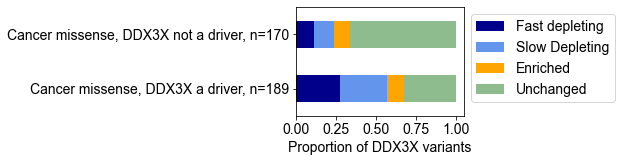

scp er10@gen3-head1://nfs/users/nfs_e/er10/SGE/DDX3X_paper/Figure_plots//Fig5A_missense_intogen_cBioPortal_vars_driver_notdriver.pdf /Users/er10/Documents/Results/SGE_data/Release_4/Figure_plots/Fig5A_missense_intogen_cBioPortal_vars_driver_notdriver.pdf


In [27]:
df = pd.read_csv(out_files+'/DDX3X_cBioPortal_driver_nondriver_missense_proportions.txt', '\t')
import matplotlib.pyplot as plt
    
# plot a Stacked Bar Chart using matplotlib

plt.rcParams["figure.figsize"] = (3,2)

df.plot(
    x = 'Tumour_type',
    kind = 'barh',
    stacked = True,
    title = 'Stacked Bar Graph',
    color=[  'darkblue','cornflowerblue','orange', 'darkseagreen'], mark_right = True)
plt.xlabel('Proportion of DDX3X variants', fontsize=14)
plt.title('')
plt.ylabel('', fontsize=14)
plt.legend(bbox_to_anchor=(1, 1), fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.savefig(out_files+'/Fig7A_missense_intogen_cBioPortal_vars_driver_notdriver.pdf', dpi=1300, bbox_inches='tight', transparent=True)
plt.show()


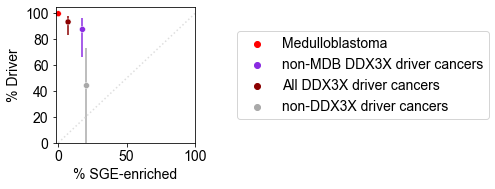

scp er10@gen3-head1://nfs/users/nfs_e/er10/SGE/data/Release_4/Figure_plots//Fig5B_dNdScv_bothsexes_merged_enriched_psubs_less05.pdf /Users/er10/Documents/Results/SGE_data/Release_4/Figure_plots//Fig5B_dNdScv_bothsexes_merged_enriched_psubs_less05.pdf


In [9]:
df=pd.read_csv(data_root+'/DDX3X_dNdScv_psubs05_drivers_w_wo_MDB_driver_proportions.txt', '\t')

color_dict = dict({'Medulloblastoma':'red', 'non-MDB DDX3X driver cancers':'blueviolet', 'All DDX3X driver cancers':'darkred',
'non-DDX3X driver cancers':'darkgrey'})
fig, ax = plt.subplots()
fig.set_size_inches(2.5,2.5)
ax.set_xlabel('% SGE-enriched', fontsize=14)
ax.set_ylabel('% Driver', fontsize=14)
ax.set_xlim(-2,100)
ax.set_ylim(0,105)
ax.plot((0,100), (0,100), alpha=0.75, color='lightgrey', zorder=0, linestyle='dotted')        
x_coords = df['% SGE-enriched']
y_coords = df['Driver variants (% of missense)']
errors=[df['plot_dNdScv_lower_bound'], df['plot_dNdScv_upper_bound']]
colors = ['red', 'blueviolet','darkred',  'darkgrey']

ax.errorbar(x_coords, y_coords, yerr=errors, ecolor = colors, fmt=' ', zorder=-1)
g=sns.scatterplot(data=df, x="% SGE-enriched", y="Driver variants (% of missense)", hue = 'dNdScv_group', palette = color_dict)
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1, fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.savefig(out_files+'/Fig7B_dNdScv_bothsexes_merged_enriched_psubs_less05.pdf', dpi=1300, bbox_inches='tight', transparent=True)
plt.show()


scp er10@gen3-head1:///nfs/users/nfs_e/er10/SGE/data/Release_4/Figure_plots//Fig5B_dNdScv_bothsexes_merged_depleted_psubs_less05.pdf /Users/er10/Documents/Results/SGE_data/Release_4/Figure_plots/Fig5B_dNdScv_bothsexes_merged_depleted_psubs_less05.pdf


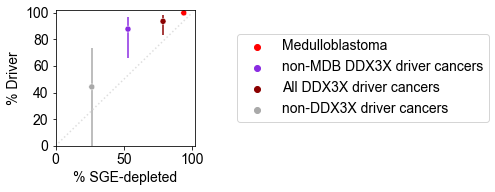

In [10]:
color_dict = dict({'Medulloblastoma':'red', 'non-MDB DDX3X driver cancers':'blueviolet', 'All DDX3X driver cancers':'darkred',
'non-DDX3X driver cancers':'darkgrey'})
fig, ax = plt.subplots()
fig.set_size_inches(2.5,2.5)
ax.set_xlabel('% SGE-depleted', fontsize=14)
ax.set_ylabel('% Driver', fontsize=14)
ax.set_xlim(0,102)
ax.set_ylim(0,102)
ax.plot((0,100), (0,100), alpha=0.75, color='lightgrey', zorder=0, linestyle='dotted')        
x_coords = df['% SGE-depleted']
y_coords = df['Driver variants (% of missense)']
errors=[df['plot_dNdScv_lower_bound'], df['plot_dNdScv_upper_bound']]
colors = ['red', 'blueviolet','darkred',  'darkgrey']

ax.errorbar(x_coords, y_coords, yerr=errors, ecolor = colors, fmt=' ', zorder=-1)
g=sns.scatterplot(data=df, x="% SGE-depleted", y="Driver variants (% of missense)", hue = 'dNdScv_group', palette = color_dict)
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1, fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.savefig(out_files+'/Fig&C_dNdScv_bothsexes_merged_depleted_psubs_less05.pdf', dpi=1300, bbox_inches='tight', transparent=True)
